# Import and requirement

In [1]:
import pickle 
import numpy as np 
import pandas as pd
import networkx as nx
from tqdm import tqdm
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from itertools import combinations

### Importing the dataset

In [36]:
movie_path = 'data/Movie.pkl'
actor_path = 'data/Actor.pkl'

with open(movie_path, 'rb') as file:
    Movie = pickle.load(file)
    
with open(actor_path, 'rb') as file:
    Actor = pickle.load(file)

# Anaylsis : Relation between actors and directors

Interesting question : \
What is the impact of directors on the network of actors ?
How does the relation between them evolve and change during time ?
Are directors hubs of actors ? 

First of all, a basic description of our data will be done in order to assess and visualize the dataset we have obtained. After that, we will do a sanity check on our database in order to verify that the research questions are indeed feasible and are interesting. Here is the global stategy that will be used in order to assess and analyse the relation between actors and directors :

1) Describe and analyze the data available on actors and directors
2) Create different networks about actors and directors 
3) Extract metrics form (networks statistics) those networks
   
if possible : 

4) Do the same for each year in order to visualize the evolution
5) Analyse the evolution of the metrics from the networks and compare them with other informatrion on the actor carrer evolution

## 1. Creating edges,node

Using the `Movie.pkl` file in order to create different network to print them later. As we are directly using the `Movie.pkl` file, we are only using the film that we successfully managed to merge between the CMU database and the IMDb database. This is intended as we will uing the directors of the movie in this part of the analysis. The directors of each movie were found using the IMDb database, hence only the film successfully merged are relevant. 

In [81]:
def get_films(df):
    # This function transforms the Freebase_movie_ID of a database into a list
    
    list_film = df.Freebase_movie_ID.tolist()
    
    return list_film

In [82]:
def create_Director_to_film_list():
    # This function uses the Movie.pkl dataset in order to create a dataframe 
    # where the first column is the director's director and the second the list of movies he directed 
    
    Movie_bis = Movie.copy()
    # Change the type of the list of index to string in order to separate and split them
    Movie_bis['IMDb_director_ID'] = Movie_bis['IMDb_director_ID'].astype(str).str.split(',')

    # Expand each director_id into its own row in order to have all director separately
    Director_Movie_expanded = Movie_bis.explode('IMDb_director_ID')

    # Group by and get_films in order to have the list of each movie the director directed 
    #Director_film_list = Director_Movie_expanded.groupby(by='IMDb_director_ID').apply(get_films,include_groups=False))
    Director_film_list = pd.DataFrame(Director_Movie_expanded.groupby(by='IMDb_director_ID').apply(get_films,include_groups=False)).reset_index()
    Director_film_list.columns = ['IMDb_director_ID','Freebase_movie_ID']
    
    # Drop the first and second row of the dataframe as they are respectively the \N and Nan index value  
    Director_film_list = Director_film_list.iloc[2:]
    
    return Director_film_list

In [83]:
def create_Film_to_Director_list():
    # This function uses the Movie.pkl dataset in order to create a dataframe 
    # where the first column is the film's unique index and the second the list of the director of the movie
    
    Movie_bis = Movie.copy()
    # Change the type of the list of index to string in order to separate and split them
    Movie_bis['IMDb_director_ID'] = Movie_bis['IMDb_director_ID'].astype(str).str.split(',')
    
    Film_director_list = pd.DataFrame()
    Film_director_list['Freebase_movie_ID'] = Movie_bis['Freebase_movie_ID']
    Film_director_list['IMDb_director_ID'] = Movie_bis['IMDb_director_ID']
    
    Film_director_list = Film_director_list.reset_index(drop=True)
    
    return Film_director_list

In [84]:
def create_Actor_to_film_list():
    # This function uses the Movie.pkl dataset in order to create a dataframe 
    # where the first column is the index's actor and the second the list of movies in which he played
    
    # load the dataset
    character_column = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_release_date','Character_name','actor_DOB','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age_atmovierelease','freebase_character_actor_map_id','freebase_character_id','Freebase_actor_ID']
    CMU_character = pd.read_csv("data/CMU/character.metadata.tsv", sep='\t',names = character_column, header = 0)

    # Filtering the rows such that only the merged movies are kept
    CMU_character_filtered = CMU_character[CMU_character['Freebase_movie_ID'].isin(Movie['Freebase_movie_ID'])]
    
    # Group by and get_films in order to have the list of each movie the actor played
    Actor_film_list = pd.DataFrame(CMU_character_filtered.groupby(by='Freebase_actor_ID').apply(get_films,include_groups=False)).reset_index()
    Actor_film_list.columns = ['Freebase_actor_ID','Freebase_movie_ID']

    return Actor_film_list

In [85]:
def create_Film_to_actor_list():
    # This function uses the Movie.pkl dataset in order to create a dataframe 
    # where the first column is the index's actor and the second the list of movies in which he played
    
    # load the dataset
    character_column = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_release_date','Character_name','actor_DOB','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age_atmovierelease','freebase_character_actor_map_id','freebase_character_id','Freebase_actor_ID']
    CMU_character = pd.read_csv("data/CMU/character.metadata.tsv", sep='\t',names = character_column, header = 0)

    # Filtering the rows such that only the merged movies are kept
    CMU_character_filtered = CMU_character[CMU_character['Freebase_movie_ID'].isin(Movie['Freebase_movie_ID'])]
    
    Film_actor_list = CMU_character_filtered.groupby('Freebase_movie_ID').agg({'Freebase_actor_ID': list}).reset_index()

    return Film_actor_list

In [86]:
def create_Director_profile():
    # This function aims to create a profile for each director, containing multiple information

    # Copy of the original dataframe
    Movie_bis = Movie.copy()  
    
    # Need to split the dataframe as there may be multiple directors per movie
    Movie_bis["IMDb_director_ID"] = Movie_bis["IMDb_director_ID"].str.split(",") 
    Movie_bis["director_name"] = Movie_bis["Producer name"].str.split(",")  
    Movie_bis["birthYear_director"] = Movie_bis["birthYear producer"].str.split(",")  
    Movie_bis["deathYear_director"] = Movie_bis["deathYear producer"].str.split(",") 

    # Explode the columns to create one row per director
    Movie_exploded = Movie_bis.explode(["IMDb_director_ID", "director_name", "birthYear_director","deathYear_director"])

    # Creating a column containg the age at the movie release using the birth year and the movie release date
    Movie_exploded["birthYear_director"] = pd.to_numeric(Movie_exploded["birthYear_director"], errors="coerce")
    Movie_exploded["Movie_release_date"] = pd.to_numeric(Movie_exploded["Movie_release_date"], errors="coerce")
    Movie_exploded["age_at_movie_release"] = (
        Movie_exploded["Movie_release_date"] - Movie_exploded["birthYear_director"]
    )

    # Group by director_ID and aggregate relevant data
    Director_profile = (
        Movie_exploded.groupby("IMDb_director_ID")
        .agg({
            "director_name": "first",  
            "birthYear_director": "first",
            "deathYear_director": "first",
            "Freebase_movie_ID": list,  
            "age_at_movie_release": list,  
        })
        .reset_index()  
    )
    return Director_profile

In [87]:
def computing_Actor_Director(Director_profile, Actor_profile):
    """
    This function checks whether an actor is also a director. As the ID are not the same, this is done using the name and the birth year.
    Returns two DataFrames:
        - ActorDirector: A DataFrame where the first column is the IMDb_director_ID, the second is the Freebase_actor_ID, 
          and the third is the name of the person.
        - ActorDirectorBirth: A DataFrame with matching individuals including their birthdate if provided in the profiles.
    """
    # Drop the nan so that it does not merge after
    Actor_profile.dropna(axis=0, subset=['actor_DOB','actor_name'], inplace=True)
    Director_profile.dropna(axis=0, subset=['birthYear_director','director_name'], inplace=True)
    
    # Change the format of the date of birth so that both are in year (Actor was YYYY-MM-DD)
    Actor_profile['actor_DOB'] = pd.to_datetime(Actor_profile['actor_DOB'], errors='coerce')
    Actor_profile['actor_DOB'] = Actor_profile['actor_DOB'].dt.year

    Director_profile['birthYear_director'] = pd.to_datetime(Director_profile['birthYear_director'], errors='coerce')
    Director_profile['birthYear_director'] = Director_profile['birthYear_director'].dt.year

    # Creating a new index based on the name of the director and its birthyear
    new_id_dir = Director_profile.birthYear_director.astype(str)+Director_profile.director_name.astype(str)
    Director_profile_newindex = Director_profile.copy()
    Director_profile_newindex.index = new_id_dir
    
    # Creating a new index based on the name of the actor and its birthyear
    new_id_act = Actor_profile.actor_DOB.astype(str)+Actor_profile.actor_name.astype(str)
    Actor_profile_newindex = Actor_profile.copy()
    Actor_profile_newindex.index = new_id_act

    # Checking for duplicate in the director index
    mask_duplicate1 = Director_profile_newindex.index.duplicated(keep=False)
    Director_profile_newindex_wo = Director_profile_newindex[~mask_duplicate1]
    
    # Checking for duplicate in the actor index
    mask_duplicate2 = Actor_profile_newindex.index.duplicated(keep=False)
    Actor_profile_newindex_wo = Actor_profile_newindex[~mask_duplicate2]

    # Finally merging the datasets
    merged = Actor_profile_newindex_wo.merge(Director_profile_newindex_wo, left_index=True, right_index=True, how='inner')
    ActorDirector = merged[['IMDb_director_ID','Freebase_actor_ID','actor_name']].reset_index(drop=True)

    return ActorDirector

In [88]:
ActorDirector = computing_Actor_Director(Director_profile, Actor)

## 2. Describing/visualizing the data

In [78]:
# Creating the profile of multiple director 
Director_profile = create_Director_profile()
print(Director_profile.shape)
print(Actor.shape)

(23518, 6)
(53282, 8)


In [71]:
Actor_bis = Actor.copy()
Director_bis = Director_profile.copy()

# Computing the start of the actor and director carrer 
# Replace NaN with -1 and ensure all values are integers
Actor_bis["actor_age_atmovierelease"] = Actor_bis["actor_age_atmovierelease"].apply(
    lambda x: [-1 if pd.isna(age) or age < 0 else int(age) for age in x]
)
Actor_bis["Career_Start_age"] = Actor_bis.apply(
    lambda row: min((val for val in row["actor_age_atmovierelease"] if val > 0), default=np.NaN),
    axis=1,
)

# Doing the same for the director
Director_bis["age_at_movie_release"] = Director_bis["age_at_movie_release"].apply(
    lambda x: [-1 if pd.isna(age) or age < 0 else int(age) for age in x]
)
Director_bis["Career_Start_age"] = Director_bis.apply(
    lambda row: min((val for val in row["age_at_movie_release"] if val > 0), default=np.NaN),
    axis=1,
)

print(Actor_bis["Career_Start_age"].mean())
print(Director_bis["Career_Start_age"].mean())

30.72403535790384
38.66550311124602


In [80]:
# Compute the number of person which were actor for movies and director for movies during their carreer 
ActorDirector = computing_Actor_Director(Director_profile, Actor)
print(Director_profile.shape)
print(Actor.shape)
print(ActorDirector.shape)

(13634, 6)
(53282, 8)
(2081, 3)


In [75]:
# Filter rows so that we only have actors who were directors and vice-versa
Actors_bis = Actor.copy()
Director_bis = Director_profile.copy()

Actor_director = Actors_bis[Actors_bis['Freebase_actor_ID'].isin(ActorDirector['Freebase_actor_ID'])]
Director_actor = Director_bis[Director_bis['IMDb_director_ID'].isin(ActorDirector['IMDb_director_ID'])]

# Computing the start of the actor and director carrer 
# Replace NaN with -1 and ensure all values are integers
Actor_director["actor_age_atmovierelease"] = Actor_director["actor_age_atmovierelease"].apply(
    lambda x: [-1 if pd.isna(age) or age < 0 else int(age) for age in x]
)
Actor_director["Career_Start_age"] = Actor_director.apply(
    lambda row: min((val for val in row["actor_age_atmovierelease"] if val > 0), default=np.NaN),
    axis=1,
)

# Doing the same for the director
Director_actor["age_at_movie_release"] = Director_actor["age_at_movie_release"].apply(
    lambda x: [-1 if pd.isna(age) or age < 0 else int(age) for age in x]
)
Director_actor["Career_Start_age"] = Director_actor.apply(
    lambda row: min((val for val in row["age_at_movie_release"] if val > 0), default=np.NaN),
    axis=1,
)

/var/folders/37/w8_bl_xd53n7dlt9q3m5v8vm0000gn/T/ipykernel_26304/558511115.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Actor_director["actor_age_atmovierelease"] = Actor_director["actor_age_atmovierelease"].apply(
/var/folders/37/w8_bl_xd53n7dlt9q3m5v8vm0000gn/T/ipykernel_26304/558511115.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Actor_director["Career_Start_age"] = Actor_director.apply(
/var/folders/37/w8_bl_xd53n7dlt9q3m5v8vm0000gn/T/ipykernel_26304/558511115.py:19: SettingWithCopyWarni

In [76]:
print(Actor_director["Career_Start_age"].mean())
print(Director_actor["Career_Start_age"].mean())

32.07150837988827
38.75860373647984


## 3. Plotting the networks

Create a network where each node is an Actor ID and create edges between actors how played together

In [136]:
def create_actor_network(Actors, min_movies=50):
    # Calculate the number of films for each actor
    Actors["Number_of_films"] = Actors["actor_age_atmovierelease"].apply(len)
    
    # Filter actors with at least `min_movies` films
    actors_with_min_x_movies = Actors[Actors["Number_of_films"] > min_movies]
    
    # Explode the DataFrame to have one row per film per actor
    actors_df = actors_with_min_x_movies.explode('Freebase_movie_ID')
    G = nx.Graph()

    # Group by movie ID and create edges for actors in the same movie
    for movie_id, group in actors_df.groupby('Freebase_movie_ID'):
        actor_ids = group['Freebase_actor_ID'].tolist()
        for actor1, actor2 in combinations(actor_ids, 2):
            if actor1 != actor2:
                if G.has_edge(actor1, actor2):
                    G[actor1][actor2]['weight'] += 1
                else:
                    G.add_edge(actor1, actor2, weight=1)

    # Add attributes to each actor node
    for _, row in actors_df.iterrows():
        actor_id = row['Freebase_actor_ID']
        if actor_id in G:
            G.nodes[actor_id].update({
                'name': row['actor_name'],
                'gender': row.get('actor_gender', None),
                'ethnicity': row.get('ethnicity', None),
                'height': row.get('actor_height', None)
            })
    return G

In [137]:
def create_director_network(Directors, min_movies=50):
    # Calculate the number of films for each director
    Directors["Number_of_films"] = Directors["age_at_movie_release"].apply(len)
    
    # Filter directors with at least `min_movies` films
    directors_with_min_x_movies = Directors[Directors["Number_of_films"] > min_movies]
    
    # Explode the DataFrame to have one row per film per director
    directors_df = directors_with_min_x_movies.explode('Freebase_movie_ID')
    G = nx.Graph()

    # Group by movie ID and create edges for directors in the same movie
    for movie_id, group in directors_df.groupby('Freebase_movie_ID'):
        director_ids = group['IMDb_director_ID'].tolist()
        for director1, director2 in combinations(director_ids, 2):
            if director1 != director2:
                if G.has_edge(director1, director2):
                    G[director1][director2]['weight'] += 1
                else:
                    G.add_edge(director1, director2, weight=1)

    # Add attributes to each director node
    for _, row in directors_df.iterrows():
        director_id = row['IMDb_director_ID']
        if director_id in G:
            G.nodes[director_id].update({
                'name': row['director_name']
            })
    return G

In [138]:
def create_actor_director_network(Actors, Movie, min_movies=50):
    # Calculate the number of films for each actor
    Actors["Number_of_films"] = Actors["actor_age_atmovierelease"].apply(len)
    
    # Filter actors with at least `min_movies` films
    actors_with_min_x_movies = Actors[Actors["Number_of_films"] > min_movies]
    
    # Explode the DataFrame to have one row per film per actor
    actors_df = actors_with_min_x_movies.explode('Freebase_movie_ID')

    # Merge actors with movies to include directors
    actors_with_directors = actors_df.merge(Movie[['Freebase_movie_ID', 'IMDb_director_ID']], on='Freebase_movie_ID', how='left')
    
    # Explode the directors list to have one row per director per actor
    actors_with_directors = actors_with_directors.explode('IMDb_director_ID')
    
    G = nx.Graph()

    # Group by director and create edges for actors working under the same director
    for director, group in actors_with_directors.groupby('IMDb_director_ID'):
        if pd.isna(director):  # Skip rows without director information
            continue
        actor_ids = group['Freebase_actor_ID'].tolist()
        for actor1, actor2 in combinations(actor_ids, 2):
            if actor1 != actor2:
                if G.has_edge(actor1, actor2):
                    G[actor1][actor2]['weight'] += 1
                else:
                    G.add_edge(actor1, actor2, weight=1)

    # Add attributes to each actor node
    for _, row in actors_with_directors.iterrows():
        actor_id = row['Freebase_actor_ID']
        if actor_id in G:
            G.nodes[actor_id].update({
                'name': row['actor_name'],
                'gender': row.get('actor_gender', None),
                'ethnicity': row.get('ethnicity', None),
                'height': row.get('actor_height', None)
            })
    
    return G

In [128]:
start_time = time.time()
G = create_director_network(Director_profile, min_movies=20)
print("Created graph with directors:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
end_time = time.time()

print("time to compute :", end_time - start_time, "seconds")

Created graph with directors:
Number of nodes: 240
Number of edges: 459
time to compute : 1.1628239154815674 seconds


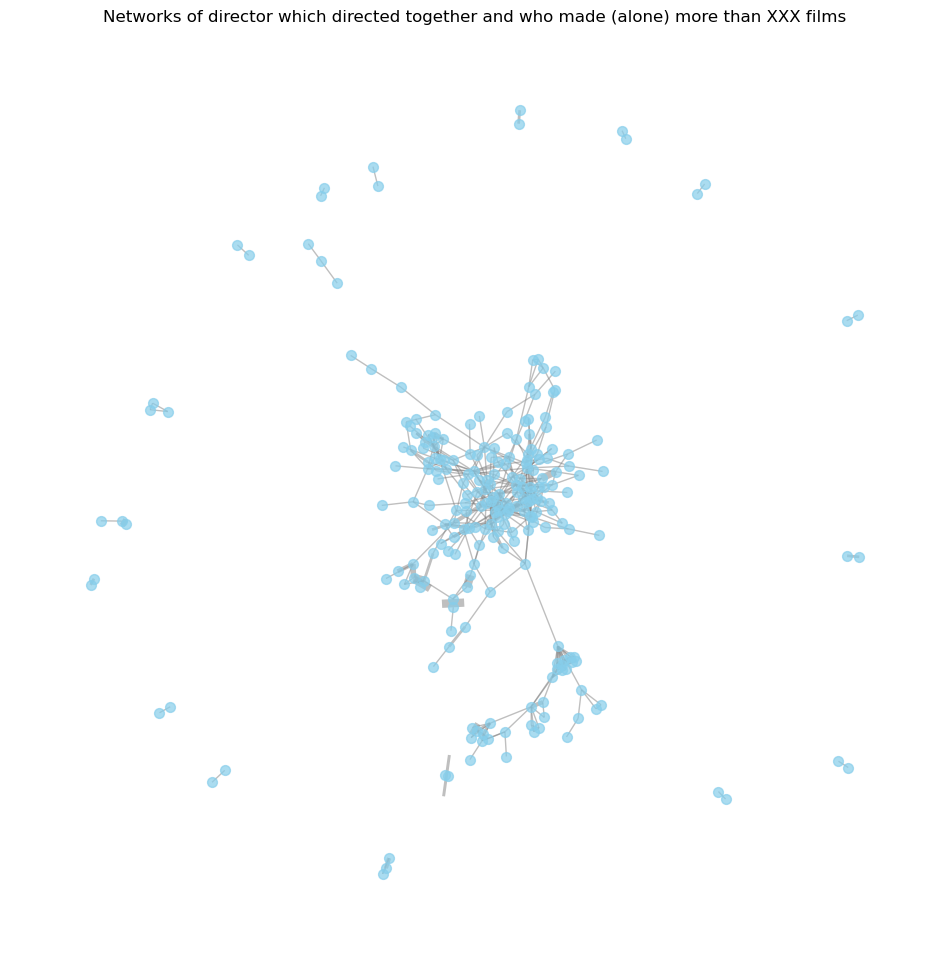

In [135]:
# Créer la position des nœuds pour une meilleure visualisation (utilise l'algorithme de disposition de force)
# Utiliser un seed pour des résultats reproductibles

pos = nx.spring_layout(G)
#pos = nx.circular_layout(G)
#pos = nx.kamada_kawai_layout(G)
#pos = nx.spectral_layout(G)

node_sizes = [G.degree(node) * 10 for node in G.nodes]

# Taille des arêtes basée sur le poids (nombre de collaborations entre deux acteurs)
edge_weights = [G[u][v]['weight'] for u, v in G.edges]
#edge_weights = 1

# Tracer le graphe
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color="skyblue", alpha=0.7)
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color="gray")
#nx.draw_networkx_labels(G, pos, {node: G.nodes[node]['name'] for node in G.nodes}, font_size=8)

plt.title("Networks of director which directed together and who made (alone) more than XXX films")
plt.axis("off")
plt.show()

In [142]:
start_time = time.time()
G = create_actor_director_network(Actor, Movie, min_movies=100)
print("Created graph with actor and directors:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
end_time = time.time()

print("time to compute :", end_time - start_time, "seconds")

Created graph with actor and directors:
Number of nodes: 74
Number of edges: 1127
time to compute : 0.7487170696258545 seconds


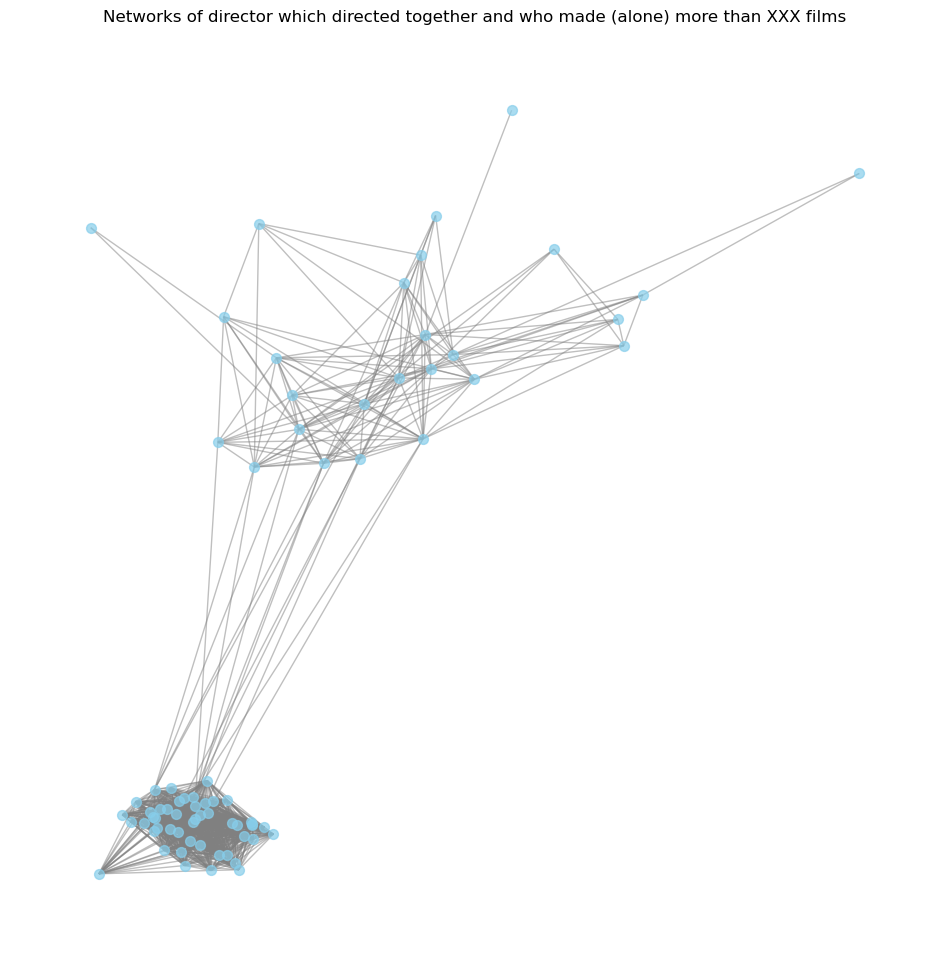

In [143]:
# Créer la position des nœuds pour une meilleure visualisation (utilise l'algorithme de disposition de force)
# Utiliser un seed pour des résultats reproductibles

pos = nx.spring_layout(G)
#pos = nx.circular_layout(G)
#pos = nx.kamada_kawai_layout(G)
#pos = nx.spectral_layout(G)

node_sizes = [G.degree(node) * 10 for node in G.nodes]

# Taille des arêtes basée sur le poids (nombre de collaborations entre deux acteurs)
#edge_weights = [G[u][v]['weight'] for u, v in G.edges]
edge_weights = 1

# Tracer le graphe
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color="skyblue", alpha=0.7)
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color="gray")
#nx.draw_networkx_labels(G, pos, {node: G.nodes[node]['name'] for node in G.nodes}, font_size=8)

plt.title("Networks of director which directed together and who made (alone) more than XXX films")
plt.axis("off")
plt.show()

## 4. Extract metrics from the network

In [62]:
start = time.time()
degrees = dict(played_together.degree())
print(f"Computation time:{time.time()-start:.2f}")

Computation time:0.17


This is too expensive to compute. Maybe try an other library ?

start = time.time()
betweenness_centrality= nx.betweenness_centrality(played_together)
print(f"Computation time:{time.time()-start:.2f}")

In [128]:
start = time.time()
eigenvector_centrality = nx.eigenvector_centrality(played_together) 
print(f"Computation time:{time.time()-start:.2f}")

Computation time:29.53
